In [1]:
import shutil
import os
import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append(os.path.abspath("../framework"))
sys.path.append(os.path.abspath("../concrete"))

In [2]:
from ConcAgent import ConcAgent
from ConcEnvironment import ConcEnvironment
from ConcAgentFactory import ConcAgentFactory
from ConcAgentMemento import ConcAgentMemento
from ConcBuildOrder import ConcBuildOrder
from ConcStore import ConcStore
from ConcObservation import ConcObservation
from framework import  ObservationSequence 
from framework import TrainId, StoreField
from workUtils import *

# 10. Misc

## 12. load trainlog into a database

In [3]:
trainLogFolderPath = "./trainLog"
cur = loadTrainLog(trainLogFolderPath)

# Table TrainLog(
#     buildOrderId Text, /* accord to a build order */
#     trainId   Text, /* accord to a trained agent along with a simulation time*/
#     timeSimulation Integer,
#     timestamp timestamp
# )

## 14. a function to load gain and bias from the trains over a training:

In [4]:
def getGainAndBiasOverTrain(buildOrderIdGiven):

    concStore = ConcStore()
    agentFactory = ConcAgentFactory()

    y = np.random.randn(1, ConcEnvironment.nPv).astype(np.float32)
    anObservationSequence = ObservationSequence()
    anObservationSequence.add(ConcObservation(y))

    cur.execute('''
    Select
        count(*)
        From TrainLog
        Where buildOrderId = ?
        ''', (buildOrderIdGiven,))
    assert cur.fetchone()[0] > 0, "NO DATA WITH THE GIVEN BUILD ID"

    cur.execute('''
    Select 
        trainId
        , timeSimulation
        , timestamp
        From TrainLog
        Where buildOrderId = ?
        Order By timeSimulation
        ''', (buildOrderIdGiven,))


    TimeSimulation = []
    Gain = []
    Bias = []

    for (trainIdStr, timeSimulation, timestamp) in cur.fetchall():

        # storeField contains: agentMement, buildOrder
        storeField = concStore.load(TrainId(trainIdStr))

        # restore agent
        agent = agentFactory.create(storeField.getBuildOrder())
        agent.loadFromMemento(storeField.getAgentMemento())
        agent(anObservationSequence)

        TimeSimulation.append(timeSimulation)
        gain = agent.gainP.weights[0].numpy()
        bias = agent.gainP.weights[1].numpy()

        Gain.append(gain)
        Bias.append(bias)

    TimeSimulation = np.array(TimeSimulation) # (*)
    Gain = np.concatenate(Gain, axis=0) # (*, nMv)
    Bias = np.stack(Bias, axis=0) # (*, nMv)
    
    return TimeSimulation, Gain, Bias

# 20. Observe the trace of gain and bias over a traing

## 22. Choose a build order

In [12]:
cur.execute('''
Select
    buildOrderId
    From TrainLog
    Order By timestamp desc
    Limit 1
    ''')

buildOrderIdGiven = cur.fetchone()[0]

## 24. Load the parameters

In [13]:
TimeSimulation, Gain, Bias = getGainAndBiasOverTrain(buildOrderIdGiven)

## 26. Plot the trace of Gain and Bias along with the simulation time

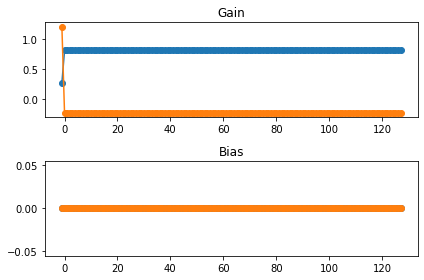

In [14]:
fig = plt.figure()
fig.clf()
#
ax = fig.add_subplot(2,1,1)
ax.plot(TimeSimulation, Gain, 'o-')
ax.set_title('Gain')
#
ax = fig.add_subplot(2,1,2)
ax.plot(TimeSimulation, Bias, 'o-')
ax.set_title('Bias')
#
plt.tight_layout()